In [ ]:
# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, Layer,Bidirectional,GRU,LSTM,Reshape,Input,Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Model

In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full.csv")
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# === Neural Field Attention Layer ===
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=5, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        attention_scores = tf.nn.softmax(u, axis=1)
        return tf.reduce_sum(attention_scores * inputs, axis=1)

In [ ]:
# === Hybrid Model ===
input_layer = Input(shape=(X_train.shape[1], 1))

# CNN Block
cnn = Conv1D(32, kernel_size=3, activation='relu')(input_layer) #unit changed to 64 from 32
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Dropout(0.2)(cnn)

# BiLSTM Block
lstm = Bidirectional(LSTM(32, return_sequences=True))(cnn) #unit changed to 32 from 64
lstm = Dropout(0.2)(lstm)

# GRU Block
gru = Bidirectional(GRU(32, return_sequences=True))(cnn)
gru = Dropout(0.2)(gru)

# Merge recurrent layers
merged = Concatenate(axis=-1)([lstm, gru])

# Attention
attention = NeuralFieldAttention(timesteps=3, lambda_strength=0.2)(merged) # timesteps changed to 3 from 5

# Dense Layers
dense = Dense(64, activation='relu')(attention)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 111, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 109, 32)        │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 54, 32)         │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 54, 32)         │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 54, 64)         │         16,640 │ dropout_10[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 54, 64)         │         12,672 │ dropout_10[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 54, 64)         │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 54, 64)         │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 54, 128)        │              0 │ dropout_11[0][0],      │
│ (Concatenate)             │                        │                │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ neural_field_attention_2  │ (None, 128)            │         16,384 │ concatenate_2[0][0]    │
│ (NeuralFieldAttention)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ neural_field_attentio… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 32)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             33 │ dropout_14[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 56,193 (219.50 KB)

 Trainable params: 56,193 (219.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Training Setup ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# === Train the model ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=64,
                    callbacks=[early_stopping, time_callback],
                    verbose=1)

Epoch 1/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - AUC: 0.8942 - Precision: 0.7223 - Recall: 0.8822 - accuracy: 0.8429 - loss: 0.3643Epoch 1 Time: 233.27s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 233s 164ms/step - AUC: 0.8943 - Precision: 0.7223 - Recall: 0.8822 - accuracy: 0.8430 - loss: 0.3642 - val_AUC: 0.9386 - val_Precision: 0.7722 - val_Recall: 0.9177 - val_accuracy: 0.8766 - val_loss: 0.2821
Epoch 2/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - AUC: 0.9314 - Precision: 0.7564 - Recall: 0.9132 - accuracy: 0.8675 - loss: 0.2948Epoch 2 Time: 211.40s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 211s 173ms/step - AUC: 0.9314 - Precision: 0.7564 - Recall: 0.9132 - accuracy: 0.8675 - loss: 0.2948 - val_AUC: 0.9511 - val_Precision: 0.7578 - val_Recall: 0.9669 - val_accuracy: 0.8803 - val_loss: 0.2705
Epoch 3/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - AUC: 0.9400 - Precision: 0.7696 - Recall: 0.9208 - accuracy: 0.8767 - loss: 0.2776Epoch 3 Time: 202.23s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 202s 173m

In [ ]:
# === Evaluation ===
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step

Metrics:
Accuracy: 0.9597
Precision: 0.9398
Recall: 0.9452
AUC: 0.9564
Confusion Matrix:
[[10974   369]
 [  334  5765]]


In [ ]:
# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


FAR: 0.0325
FRR: 0.0548


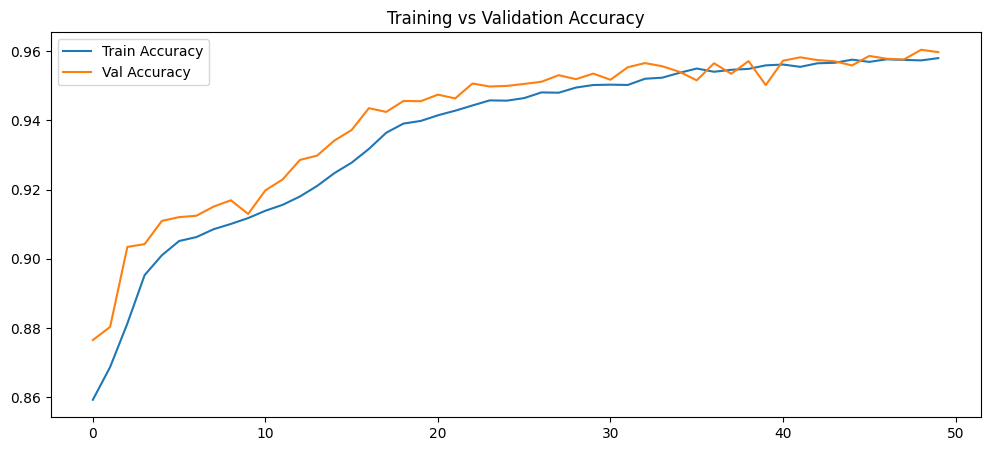

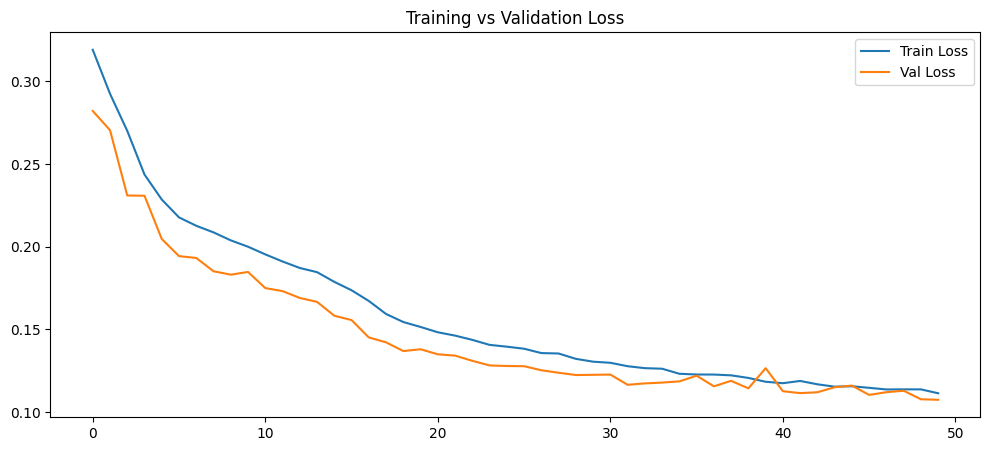

In [ ]:
# Plot training history
np.save("model_history_hybrid.npy", history.history)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()